# 4. Slow and Fast time weightings
------------

In this notebook we'll be focusing on the **Slow and Fast time-weighting filters**. These filters were widely used in traditional sound level meters, where an analog and adjustable RC integrator that defined the speed at which the indicator "moved" according to the measured levels. The objective of this was to make it easier to read the displayed sound levels.

## Filter definition

Both filters consists of applying a **one-pole low-pass filter to the squared signal**, whose transfer function is defined by the equation below: 

$$H(S) = \dfrac{1}{1+ \tau s}$$

In the case of applying the **Slow time-weigthing the parameter $\tau$ (representing the location of the pole) is 1 s, whereas $\tau$ is 125 ms for the Fast time-weighting**. Next, we'll define basic constants, and create a function to get the **coefficients for a second-order-section low-pass Butterworth filter, by specifying the parameter $\tau$**.

In [1]:
import numpy as np
from scipy.signal import butter

# Sampling frequency
FS = 48000

# Slow time constant
S = 1.0 # S
# Fast time constant
F = 0.125 # S

def generate_weighting_filter(t=1.0, fs=FS):
    """ Generates the coefficients for a second-order-section
    'Slow' or 'Fast' time-weighting filter, according to the
    time constant 't' and the sampling frequency 'fs'. """
    return butter(1, 1/(np.pi*t*fs), output='sos')

sos_S = generate_weighting_filter(S)
sos_F = generate_weighting_filter(F)

## Displaying the filter's behaviour

Above, we successfully created the desired function and computed the coefficients for both filters, which means we are ready to apply them to our audio signals.

Next we'll create an **example signal of 40 dB that instantaneuosly reaches 60 dB before returning back to the 40 dB level after 5 seconds**. Based on that signal **we'll compare the instantaneous sound level with the ones resulting form applying the time-weighting filters**.

In [2]:
from scipy.signal import sosfilt

x = np.zeros(18*FS)
x[:] = 10**(40/20)
x[5*FS:10*FS] = 10**(60/20)

x_S = np.sqrt(sosfilt(sos_S, x**2))
x_F = np.sqrt(sosfilt(sos_F, x**2))

`x_S` and `x_F` represent our example signal with both the Slow and Fast time-weightings applied (respectively). Let's **plot the sound level of both of these signals and that of the un-weighted signal**.

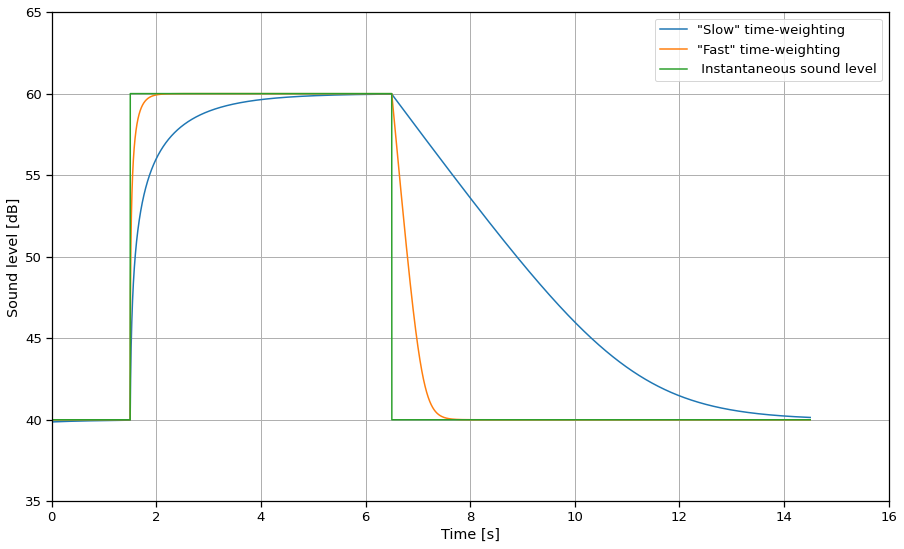

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# time offset
offset = -3.5 # s

plt.plot(offset + np.arange(len(x))/FS, 20*np.log10(x_S), label='"Slow" time-weighting')
plt.plot(offset + np.arange(len(x))/FS, 20*np.log10(x_F), label='"Fast" time-weighting')
plt.plot(offset + np.arange(len(x))/FS, 20*np.log10(x), label=' Instantaneous sound level')

plt.xlabel('Time [s]')
plt.ylabel('Sound level [dB]')
plt.xlim([0, 16])
plt.ylim([35, 65])
plt.legend()
plt.grid('on', which='both')

From the image above the effect of applying these filters can be appreciated. What's perhaps most noticeable it's the amount of times it takes to the Slow time-weighted values to reach those of the un-weighted signal. It takes **more than 6 seconds for the displayed Slow levels to reach the value of the signal**.

Contrary to computing and storing the instantaneous sound pressure levels it's more convenient to **integrate sound pressure level over a specific period of time**, one second for example. We'l define the different ways of measuring and specifying sound pressure levels in the next notebook. For now, we'll specify a function to **compute the root-mean-squared (RMS) value of a signal over a specific period of time**. This will allow us to then **calculate and compare the equivalent, and the Slow and Fast time-weighted sound pressure levels**.

In [4]:
def rms(x):
    """ RMS level calculatiaon for the input signal 'x'. """
    return np.sqrt(np.mean(x**2))

def rms_t(x, t=1.0, fs=FS):
    """ RMS level calculation for the input signal 'x',
    in fragments of length 't'. """
    x = np.array(x, dtype='float64')
    N = int(np.floor(t*fs))
    start = np.arange(0, len(x), N) 
    end = np.append(start[1:], x.shape[0])
    y= np.empty(len(start))
    for i in range(len(start)):
        y[i] = rms(x[start[i]:end[i]])
    return y

## Applying the filters to a recorded tone

Now we'll load a recording made by the device consisting of an acoustic monitor reproducing a 1 kHz tone for 5 s and we'll **calculate the levels in 125 ms time intervals**.

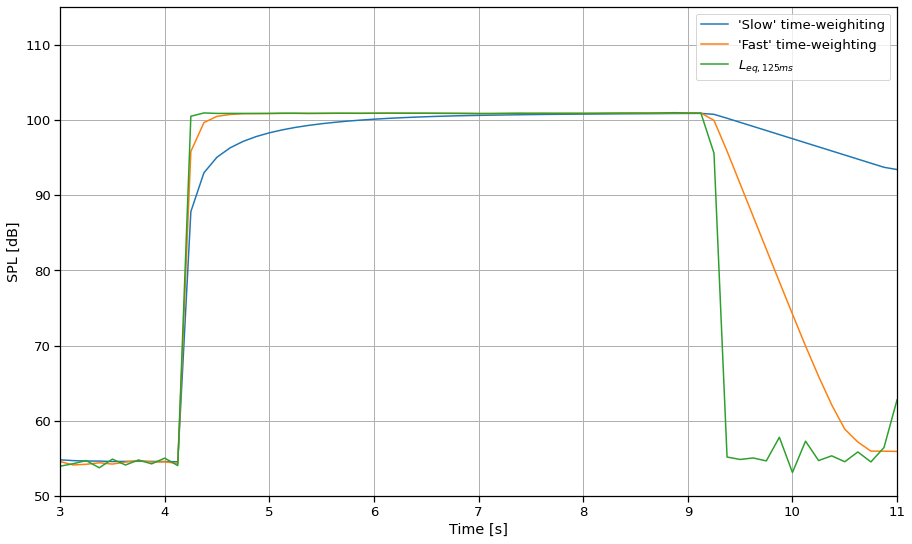

In [5]:
from scipy.signal import sosfilt

from sys import path
import os

path_parent = os.path.dirname(os.getcwd())
path.append(path_parent + '\\src') 

# importing from our utils module
from utils import wavread

# Loading and processing audio
# - - - - - - - - - - - - - - -

# load audio
fs, tone = wavread('../aud/tone_1k.wav')
# eliminating microphone's offset
tone = tone/np.mean(tone)-1

# load calibration file
_, cal = wavread('../aud/cal.wav')
# eliminating microphone's offset
cal = cal/np.mean(cal)-1

# applying time-weighting filters
tone_S = np.sqrt(sosfilt(sos_S, tone**2))
tone_F = np.sqrt(sosfilt(sos_F, tone**2))

# getting RMS levels for 125 ms time intervals
F = 0.125
rms_x = rms_t(tone, t=F)
rms_S = rms_t(tone_S, t=F)
rms_F = rms_t(tone_F, t=F)

# Plotting
# - - - - - - - - - - - - - - -

# time vector in seconds
x_t = np.arange(0, len(rms_x)*F, F)

# calculating sound pressure levels and plotting
plt.plot(x_t, 94 + 20*np.log10(rms_S/rms(cal)), label="'Slow' time-weighiting")
plt.plot(x_t, 94 + 20*np.log10(rms_F/rms(cal)), label="'Fast' time-weighting")
plt.plot(x_t, 94 + 20*np.log10(rms_x/rms(cal)), label='$L_{eq,125ms}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([3, 11])
plt.ylim([50, 115])
plt.legend()
plt.grid('on', which='both')

The recorded tone moves in level from around 55 dB to 100 dB. We can see that the Fast indication closely follows the equivalent measurement when the tone is reproduced, and takes around a second to reach the background level after the it finishes. **The Fast indication has a decay of about 35 dB/s, while this value is of 4 dB/s for its Slow counterpart**.

## Conclusion

In this notebook we applied on digital signals the **time-weighting that was traditionally done on sound level meters to have a more stable reading of the sound pressure levels**. We clearly saw the difference in how the Slow and Fast weightings respond to the changes in our signal's level.

In the next notebook we'll further specify the main parameters for the measurement of acoustical noise levels, and we'll generate functions that will allow us to calculate them through our device.